# DINOSAUR NAMES GENERATOR


Today we will implement a **RNN** that generates dinos names.

We are going to use a **sequence-to-sequence** (seq2seq) model: given a part of a name (sequence of data) we generate the next characters.

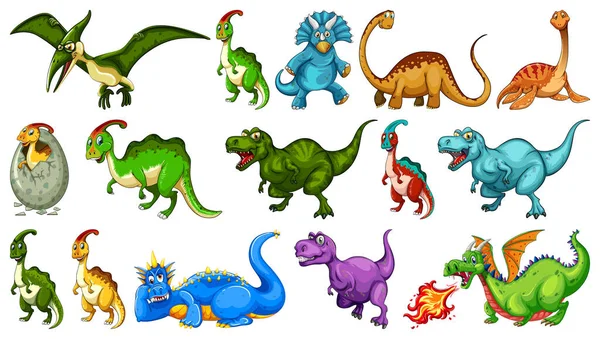

## Exercise setting
You have to complete the cells with the `#TO-DO` marks within (if possible) the specified time. Then, we will provide the solution of that cell and move on the ones after that.
Remember to remove the `raise NotImplementedError` lines after you completed the `#TO-DO`.

If you fall behind, you can copy-paste from the solution (which is already available). If the tasks are too easy, you can continue the exercise.

Remark 1: the solution is already available to avoid falling behind, but try to think about what you are doing without copying it blindly.

Remark 2: there's not an unique solution, so if you find something that works, that's great, but try to keep the notation we use as much as possible to avoid conflicts.

This exercise is largely inspired from the following article:
https://medium.com/analytics-vidhya/generating-dinosaur-names-with-pytorch-ee839e97bb76


# 1) Getting started

## 1.1) Imports (as usual)

In [5]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

In [6]:
torch.manual_seed(42)

## 1.2) Load and prepare the data
We train our model on real dinosaurs names: download them from https://gist.github.com/judahsemi/210d42e0410c122aa0e437861c46cf94 and put the `dinos.txt` file in the colab/kaggle/local folder.

In [7]:
def split_to_names(fname):
    """
    Return a list of lists containing the characters with the end-of-sequence
    character.
    """
    EOS = "<EOS>"
    data = []

    with open(fname) as file:
        text = file.read().lower()      # lower cases

    names = text.splitlines()           # returns list of lines
    for name in names:
        ch_list = list(name) + [EOS]    # split names to chars and concat EOS
        data.append(ch_list)

    return data

In [8]:
data_in_char = split_to_names("./Datasets/dinos.txt")

In [9]:
data_in_char[0:2]

[['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '<EOS>'],
 ['a', 'a', 'r', 'd', 'o', 'n', 'y', 'x', '<EOS>']]

### TO-DO 1 (estimated time: 10 minutes)
Our model is not able to understand what characters are, so we have to map them into numbers.

Define:
*   a list named `char_vocab` containing our vocabulary (check `string.ascii_lowercase` for that), i.e. the 26 letters plus `"<EOS>"` (end of sequence) and `"PAD"` (padding) special characters. Put `"<EOS>"` as the first element and `"PAD"` as the last one.
*   a dictionary named `char_to_ix` representing a mapping from characters (keys) of our `char_vocab` to integer (values).
* a dictionary named `ix_to_char` representing the inverse of `char_to_ix`, i.e. a mapping from integer (keys) to characters (values).



In [10]:
# TO-DO 1
# char_vocab =
# char_to_ix =
# ix_to_char =

In [11]:
# @title TO-DO 1 (solution)
char_vocab = ["<EOS>"] + sorted([ch for ch in string.ascii_lowercase]) + ["PAD"]
char_to_ix = {ch:i for i,ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch,i in char_to_ix.items()}

# 2) Create the dataset
Given a mapping (or dictionary) `map`, the following `keys_to_values()` helper function allows us to retrieve the value given the key.

In [12]:
def keys_to_values(keys, map, default_if_missing=None):
    return [map.get(key, default_if_missing) for key in keys]

### TO-DO 2 (estimated time: 15 minutes)
Now we create a class `Dataset` that inherits from `torch.utils.data.Dataset`. In particular, you have to define:


*   an `__init__` method that creates a list named `self.data_as_int` containing all the names of the dinos in **integer** form (you can use the helper function `keys_to_values()`).
*   a `__len__` method that returns the length of the datast.
* a `__getitem__` method that, given an index, returns two torch tensors associated to the element of the dataset at that index: the first one contains all the elements of that index except the last one, and the second one contains all the elements of that index except the first one (remark: we are doing character by character prediction).

In [13]:
# TO-DO 2
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, map):
        # self.data_as_int =
        raise NotImplementedError

    def __len__(self):
        # return ...
        raise NotImplementedError

    def __getitem__(self, ix):
        #return ..., ...
        raise NotImplementedError

In [14]:
# @title TO-DO 2 (solution)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, map):
        self.data_as_int = []

        # Convert characters to integers
        for seq_as_str in data_as_str:
            seq_as_int = keys_to_values(seq_as_str, map,
                                        random.choice(list(map)))

            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]

        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)

**Remark:** if we use `batch_size>1`, we have to pad the sequences. We can do it easily using `nn.utils.rnn.pad_sequence()` directly on the `Dataset` class, but it would be inefficient since we have to pad all the sequences with the maximal length of all the dataset.
Instead, we define a `collate_fn()` function and call it in the `DataLoader()`, which automatically pads **only one batch** at each call of the dataloader. Note that the `padding_value` is the integer key corresponding to the `"PAD"` special character (provided with the lambda function).

In [15]:
def collate_fn(batch, pad_value):
  data, targets = zip(*batch)

  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True,
                                          padding_value=pad_value)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True,
                                             padding_value=pad_value)

  return padded_data, padded_targets

In [16]:
batch_size = 8
dataset = Dataset(data_in_char, char_to_ix)
if batch_size == 1:
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
  dataloader = DataLoader(dataset, batch_size=batch_size,
                          collate_fn=lambda b: collate_fn(b, char_to_ix["PAD"]),
                          shuffle=True)


# 3) Define the model
Now we are going to define our model, that inherits from `nn.Module` and contains three methods, i.e. `__init__`, `__forward__`, and `init_state`.
While the first two are more common, we require the additional `init_state` since we have to initialize also the first hidden state of RNN.

### TO-DO 3 (estimated time: 10 minutes)
Complete the `__init__` as follows:


*   define a `self.embedding` attribute that creates an embedding of our vocabulary, i.e. a mapping from the characters to a tensor (check `torch.nn.Embedding` and remember that you must pass also a `padding_idx`, that can be obtained from `map`).
*   define a `self.rnn` attribute (use the flag `batch_first=True`); you can eventually add dropout.
* define a linear layer `self.fc` that output unnormalized logits of the vocabulary values given the hidden state.



In [17]:
# TO-DO 3
class Model(nn.Module):
    def __init__(self, map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        super(Model, self).__init__()

        self.vocab_size  = len(map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p

        # define embedding
        # self.embedding =

        # define rnn
        # self.rnn =

        # define linear
        # self.fc =

        raise NotImplementedError

    def forward(self, x, prev_state):

        embed = self.embedding(x)
        yhat, state = self.rnn(embed, prev_state)   # yhat is the full sequence prediction, while state is the last hidden state (coincides with yhat[-1] if n_layers=1)

        yhat = self.dropout(yhat)
        out = self.fc(yhat)

        return out, state

    def init_state(self, b_size=1):
        return torch.zeros(self.n_layers, b_size, self.hidden_size)



In [18]:
# @title TO-DO 3 (solution)
class Model(nn.Module):
    def __init__(self, map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        super(Model, self).__init__()

        self.vocab_size  = len(map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p

        # dimensions: batches x seq_length x emb_dim
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim,
            padding_idx=map["PAD"])

        self.rnn = nn.RNN(input_size=self.emb_dim,
                          hidden_size=self.hidden_size,
                          num_layers =self.n_layers,
                          batch_first=True)

        self.dropout = nn.Dropout(self.dropout_p)

        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        yhat, state = self.rnn(embed, prev_state)   # yhat is the full sequence prediction, while state is the last hidden state (coincides with yhat[-1] if n_layers=1)

        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state

    def init_state(self, b_size=1):
        return torch.zeros(self.n_layers, b_size, self.hidden_size)



# 4) Training Loop
We now define the training phase.


### TO-DO 4 (estimated time: 10 minutes)
Complete the `train()` function with the missing parts.

Remark (1): if you used non-bounded activation functions (e.g. ReLU instead of tanh) you have to use also the clipping gradient (check https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html).

Remark (2): the `nn.CrossEntropyLoss` criterion automatically casts the unnormalized logits of the classes into probabilities, but you must put classes as the second dimension of the tensor (the output has dimension `batch x seq_length x vocab_size`, so you need to transpose it).
Remember also that the softmax is included.

In [19]:

def train(model, data, num_epochs, criterion, lr=0.001, print_every=50, clip=None):
    model.train()

    costs = []
    running_loss = 0
    loss_hist = []

    # optimizer = # choose you favourite optimizer

    epoch = 0
    while epoch<num_epochs:
        epoch += 1
        for x, y in data:
            # optimizer.zero_grad() # uncomment this after you choose the optimizer

            # Initialise model's internal state and do the forward propagation:
            # prev_state =
            # out, state =

            # Calculate loss
            # loss =
            # costs.append(loss.item())   # uncomment this after you defined the loss
            # running_loss += loss.item() # uncomment this after you defined the loss

            # Calculate gradients (backward)
            # loss.backward()

            # Do clipping (if needed)
            # if clip:
                # ...

            # optimizer.step() # uncomment this after you choose the optimizer

            raise NotImplementedError

        if print_every and (epoch%print_every)==0:
          print("Epoch: {}/{}, Loss: {:8.4f}".format(
                    int(epoch), int(num_epochs),
                    running_loss/float(print_every*len(data))))
          loss_hist.append(running_loss/float(print_every*len(data)))
          running_loss = 0

    return model, costs, loss_hist

In [20]:
# @title TO-DO 4 (solution)
def train(model, data, num_epochs, criterion, lr=0.001, print_every=50, clip=None):
    model.train()

    costs = []
    running_loss = 0
    loss_hist = []

    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch = 0
    while epoch<num_epochs:
        epoch += 1
        for x, y in data:
            optimizer.zero_grad()
            # Initialise model's state and perform forward-prop
            prev_state = model.init_state(b_size=x.shape[0])
            out, state = model(x, prev_state)         # out has dim: batch x seq_length x vocab_size

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)  #transpose is required to obtain batch x vocab_size x seq_length
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if print_every and (epoch%print_every)==0:
          print("Epoch: {}/{}, Loss: {:8.4f}".format(
                    int(epoch), int(num_epochs),
                    running_loss/float(print_every*len(data))))
          loss_hist.append(running_loss/float(print_every*len(data)))
          running_loss = 0

    return model, costs, loss_hist

### Train the model
Remarks on criterion:
* the softmax is included, so we have to pass unnormalized logits.
* the flag `ignore_index` allows to automatically detect padded values (check the argument of `pad_sequence`) and exclude them when calculating the value of the loss.

In [21]:

criterion = nn.CrossEntropyLoss(ignore_index=char_to_ix["PAD"])
model = Model(char_to_ix, 64, 8, n_layers=2, dropout_p=0.2)
model, costs, loss_history = train(model, dataloader, 50, criterion, lr=1e-3,
                                   print_every=2)

Epoch: 2/50, Loss:   2.1803
Epoch: 4/50, Loss:   1.8460
Epoch: 6/50, Loss:   1.7527
Epoch: 8/50, Loss:   1.6881
Epoch: 10/50, Loss:   1.6466
Epoch: 12/50, Loss:   1.6195
Epoch: 14/50, Loss:   1.5823
Epoch: 16/50, Loss:   1.5536
Epoch: 18/50, Loss:   1.5255
Epoch: 20/50, Loss:   1.5081
Epoch: 22/50, Loss:   1.4827
Epoch: 24/50, Loss:   1.4636
Epoch: 26/50, Loss:   1.4449
Epoch: 28/50, Loss:   1.4270
Epoch: 30/50, Loss:   1.4103
Epoch: 32/50, Loss:   1.3944
Epoch: 34/50, Loss:   1.3804
Epoch: 36/50, Loss:   1.3663
Epoch: 38/50, Loss:   1.3562
Epoch: 40/50, Loss:   1.3416
Epoch: 42/50, Loss:   1.3183
Epoch: 44/50, Loss:   1.3162
Epoch: 46/50, Loss:   1.2987
Epoch: 48/50, Loss:   1.2905
Epoch: 50/50, Loss:   1.2816


### Loss visualization

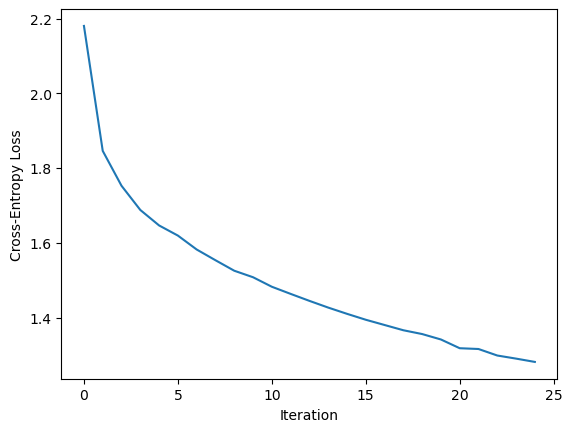

In [22]:
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.plot(np.array(loss_history))

# 5) Now create your dino name!
We are now almost ready to play with our model, but to do that we have to define two additional functions:
* `sample_next()`: get the vocabulary values of the last element of the sequence, consider the top-k values, and sample from those values using a softmax (to add stochasticity). Remark: `out` has dimensions `(batch, seq_length, vocab_size
)`, so we need all the elements corresponding to the -1 position in the sequence dimension.
* `sample()`: given a starting seed (single random character or sequence), sample the full name untill `stop_on` character is found or `max_seqlen` is reached.


In [23]:
def sample_next(model, x, prev_state, topk=5, uniform=True):
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]    # vocabulary values of last element of sequence

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)

    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix, p=p)

    return sampled_ix, state

In [24]:
def sample(model, seed, topk=5, uniform=True, max_seqlen=18, stop_on=None):
    seed = seed if isinstance(seed, (list, tuple)) else [seed]

    model.eval()
    with torch.no_grad():
        sampled_ix_list = seed[:]
        x = torch.tensor([seed])

        prev_state = model.init_state(b_size=1)
        for t in range(max_seqlen - len(seed)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)

            sampled_ix_list.append(sampled_ix)
            x = torch.tensor([[sampled_ix]])

            if sampled_ix==stop_on:
                break

    model.train()
    return sampled_ix_list

In [25]:
print(">>> Samples where seed is a randomly chosen character (except for <EOS>).")
for i in range(10):
    seed = random.choice(list(char_to_ix.values())[1:-1])
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))


>>> Samples where seed is a randomly chosen character (except for <EOS>).
19 => shandong<EOS>
17 => qillodocheusaurus<EOS>
13 => melimia<EOS>
14 => natisaurus<EOS>
3 => camphophanthodon<EOS>
17 => qiganosaurus<EOS>
15 => odocamenosaurus<EOS>
7 => grachaesaurus<EOS>
11 => kelechalesaurus<EOS>
6 => fendocus<EOS>


In [26]:
word='tom'

In [27]:
print(">>> Samples where seed is a list of character.")
for i in range(10):
    seed = keys_to_values(list(word), char_to_ix, None)
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

>>> Samples where seed is a list of character.
[20, 15, 13] => tomacthi<EOS>
[20, 15, 13] => tomong<EOS>
[20, 15, 13] => tomandosaurus<EOS>
[20, 15, 13] => tomanchus<EOS>
[20, 15, 13] => tomerosaurus<EOS>
[20, 15, 13] => tomomimus<EOS>
[20, 15, 13] => tomosaurus<EOS>
[20, 15, 13] => tomong<EOS>
[20, 15, 13] => tomimus<EOS>
[20, 15, 13] => tomestes<EOS>
